# Assignment 1 - mkecera3@gatech.edu

## Import libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score, silhouette_score
from sklearn import metrics
import torch.nn.functional as F
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans, FeatureAgglomeration
from scipy.stats import mode, kurtosis
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import Normalizer
from sklearn import random_projection

In [2]:
savePath = ''

## Load and save the datasets

Start of citation - the following code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

## Neural network

### MNIST dataset

In [4]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [5]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [6]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [7]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [8]:
lossDataBaseline, accDataBaseline, runtime = trainNN(model)

Epoch 0 - Training loss: 1.1941311765281135
Testing Loss  = 0.4913928937760128
Epoch 1 - Training loss: 0.4138153123543086
Testing Loss  = 0.37014033498278087
Epoch 2 - Training loss: 0.3443558330235579
Testing Loss  = 0.31989101239830064
Epoch 3 - Training loss: 0.31140289339415556
Testing Loss  = 0.29640919791095577
Epoch 4 - Training loss: 0.28701211516852576
Testing Loss  = 0.27585583033075756
Epoch 5 - Training loss: 0.2667836829581681
Testing Loss  = 0.25667491982317275
Epoch 6 - Training loss: 0.24809053269646053
Testing Loss  = 0.2412581970547415
Epoch 7 - Training loss: 0.23207008834842527
Testing Loss  = 0.2243424855931929
Epoch 8 - Training loss: 0.21525701972872704
Testing Loss  = 0.2139939529595861
Epoch 9 - Training loss: 0.20215209862669867
Testing Loss  = 0.20263669722873695
Epoch 10 - Training loss: 0.18897158422452562
Testing Loss  = 0.1911136807909437
Epoch 11 - Training loss: 0.176311589579772
Testing Loss  = 0.17771214379626474
Epoch 12 - Training loss: 0.166354118

In [9]:
print(np.mean(runtime))
# print(runtime)

10.446956817309061


In [10]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [11]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

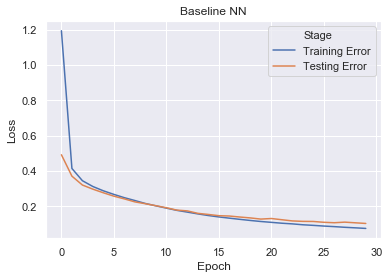

In [12]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 Baseline NN')

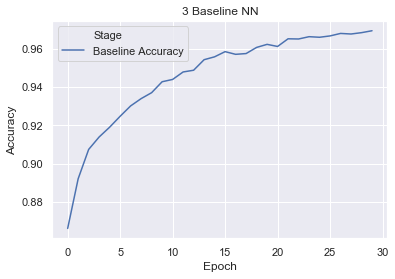

In [13]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 Baseline NN')

In [14]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [15]:
correctCount / allCount

0.9713

End of citation - the preceding code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627





### Credit default dataset

In [16]:
# load dataset
creditDataDf = pd.read_excel(savePath + './data/default of credit card clients.xls', header=1)
creditDataDf = creditDataDf.drop(columns=['ID'])

In [17]:
print(sum(creditDataDf['default payment next month']))
print(len(creditDataDf))
print(sum(creditDataDf['default payment next month'])/len(creditDataDf))


6636
30000
0.2212


In [18]:
# create dummy variables from categorical
creditDataDf = pd.get_dummies(creditDataDf, prefix=['SEX', 'EDUCATION', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [19]:
# drop last mummy variable
creditDataDf = creditDataDf.drop(columns=['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'])

In [20]:
y = creditDataDf['default payment next month']
creditDataDf = creditDataDf.drop(columns=['default payment next month'])

In [21]:
dfColumns = creditDataDf.columns

In [22]:
# balance the dataset
ros = RandomOverSampler(random_state=37)
creditDataDf, y = ros.fit_resample(creditDataDf, y)

In [23]:
creditDataDf = pd.DataFrame(creditDataDf, columns=dfColumns)

In [24]:
print(sum(y)/len(y))

0.5


In [25]:
# standardize the data
x = creditDataDf.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
creditDataDf = pd.DataFrame(x_scaled, columns=creditDataDf.columns)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(creditDataDf, y, test_size=0.2, random_state=37)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=37)

In [27]:
print(X_train.columns)
print(len(X_train.columns))

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2'],
      dtype='object')
30


In [28]:
sum(y_train)/len(y_train)

0.5023909045310149

In [29]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val.values.astype(np.float32))

y_train_tensor = torch.tensor(y_train.values.astype(np.int))
y_test_tensor = torch.tensor(y_test.values.astype(np.int))
y_val_tensor = torch.tensor(y_val.values.astype(np.int))

In [30]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [31]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

7477 9346 29905


In [32]:
trainloader2 = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader2 = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader2 = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [33]:
def nnPredictTabular(model2, valloader2, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    probList = []
    for rows,labels in valloader2:
        
#         print(rows.shape)
#         print(labels.shape)
        
        with torch.no_grad():
                output = model2(rows)
                loss = criterion(output, labels)
                running_loss += loss.item()


        for i in range(len(labels)):
            row = rows[i].view(1, 30)
#             print(row.shape)
            with torch.no_grad():
                logps = model2(row)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            probList.append(probab)
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader2)))
    
    return running_loss/len(valloader2), correct_count, all_count, probList

In [34]:
input_size = 30
hidden_sizes = [25, 15]
output_size = 2

modelTabBaseline = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [35]:
def trainTabNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # optimizer = optim.Adam(model.parameters(), lr=0.01)
    time0 = time()
    epochs = 100
    lossData = []
    accData=[]
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for rows, labels in trainloader2:
                
            # Training pass
            optimizer.zero_grad()
            
            output = model(rows)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader2)))
            
        testingLoss, correctCount, allCount, proba = nnPredictTabular(model, valloader2, criterion)
        print("Testing Loss  =", (testingLoss))
        print("Testing Accuracy  =", (correctCount / allCount))
        
        lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
        lossData.append([e, testingLoss, 'Testing Loss'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime
        
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [36]:
lossDataBaseline, accDataBaseline, runtime = trainTabNN(modelTabBaseline)

Epoch 0 - Training loss: 0.6518097282984318
Testing Loss  = 0.6182771921157837
Testing Accuracy  = 0.6673799652266952
Epoch 1 - Training loss: 0.6056054666893095
Testing Loss  = 0.5929823517799377
Testing Accuracy  = 0.6919887655476795
Epoch 2 - Training loss: 0.5894415445434742
Testing Loss  = 0.5817205309867859
Testing Accuracy  = 0.6988096830279524
Epoch 3 - Training loss: 0.5818805562762114
Testing Loss  = 0.5758105516433716
Testing Accuracy  = 0.706299317908252
Epoch 4 - Training loss: 0.5769632207786936
Testing Loss  = 0.5707201957702637
Testing Accuracy  = 0.7053631135482146
Epoch 5 - Training loss: 0.5740195086114427
Testing Loss  = 0.5690211653709412
Testing Accuracy  = 0.7060318309482413
Epoch 6 - Training loss: 0.5712750208938223
Testing Loss  = 0.5646457076072693
Testing Accuracy  = 0.7095091614283804
Epoch 7 - Training loss: 0.5694500550500348
Testing Loss  = 0.5629348158836365
Testing Accuracy  = 0.7121840310284874
Epoch 8 - Training loss: 0.5677890800512754
Testing Loss 

Testing Loss  = 0.5397835969924927
Testing Accuracy  = 0.7238197137889528
Epoch 70 - Training loss: 0.5382211887810984
Testing Loss  = 0.5408797264099121
Testing Accuracy  = 0.7239534572689581
Epoch 71 - Training loss: 0.5386420613807491
Testing Loss  = 0.5432384610176086
Testing Accuracy  = 0.7219473050688779
Epoch 72 - Training loss: 0.5380073005062902
Testing Loss  = 0.5378915667533875
Testing Accuracy  = 0.7247559181489902
Epoch 73 - Training loss: 0.5370608135166332
Testing Loss  = 0.5442328453063965
Testing Accuracy  = 0.7129864919085195
Epoch 74 - Training loss: 0.5371956228573098
Testing Loss  = 0.5380584001541138
Testing Accuracy  = 0.7275645312291026
Epoch 75 - Training loss: 0.536591574931756
Testing Loss  = 0.5386017560958862
Testing Accuracy  = 0.7238197137889528
Epoch 76 - Training loss: 0.5367253642433729
Testing Loss  = 0.5413598418235779
Testing Accuracy  = 0.7232847398689314
Epoch 77 - Training loss: 0.5360069149452397
Testing Loss  = 0.5408521890640259
Testing Accura

In [37]:
print(np.mean(runtime))
# print(runtime)

1.1387806916236878


In [38]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabBaseline, testloader2, criterion)

In [39]:
correctCount/allCount

0.7180612026535417

In [40]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

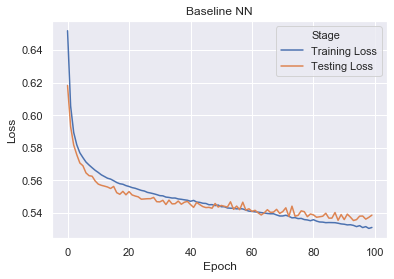

In [41]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Baseline NN')

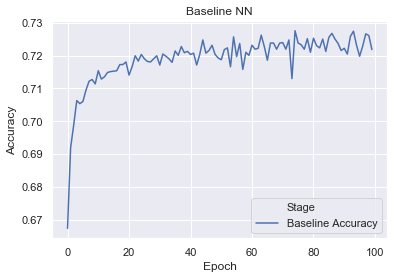

In [42]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Baseline NN')

# Clustering algorithms

## MNIST

In [43]:
np_MNIST_trainset = np.nan_to_num(trainset.dataset.data.numpy())
np_MNIST_testset = np.nan_to_num(testset.data.numpy())

np_MNIST_trainset_y = np.nan_to_num(trainset.dataset.targets.numpy())
np_MNIST_testset_y = np.nan_to_num(testset.targets.numpy())

In [44]:
np_MNIST_trainset, np_MNIST_valset, np_MNIST_trainset_y, np_MNIST_valset_y = train_test_split(
    np_MNIST_trainset, np_MNIST_trainset_y, test_size=10000, random_state=42
    )

In [45]:
np_MNIST_trainset = np_MNIST_trainset.reshape(50000, 784)
np_MNIST_testset = np_MNIST_testset.reshape(10000, 784)
np_MNIST_valset = np_MNIST_valset.reshape(10000, 784)

### K-MEANS

In [46]:
# calculating optimal number of clusters
silhouette_scores = []
elbow_scores = []

for i in np.arange(2, 20, 2):
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    silhouette_scores.append(silhouette_score(np_MNIST_trainset, kmeans.fit_predict(np_MNIST_trainset)))
    elbow_scores.append(kmeans.inertia_)

Text(0.5, 1.0, 'Silhouette scores - MNIST')

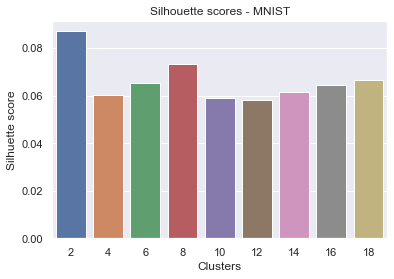

In [47]:
x = np.arange(2, 20, 2)
sns_plot = sns.barplot(x=x, y=silhouette_scores)
sns_plot.set(xlabel='Clusters', ylabel='Silhuette score')
sns_plot.set_title('Silhouette scores - MNIST')

Text(0.5, 1.0, 'Elbow method - MNIST')

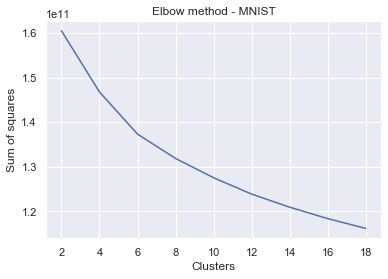

In [48]:
sns_plot = sns.lineplot(x=x, y=elbow_scores)
sns_plot.set(xlabel='Clusters', ylabel='Sum of squares')
sns_plot.set_title('Elbow method - MNIST')

In [49]:
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset)

In [50]:
# Some of the following was inspired by: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

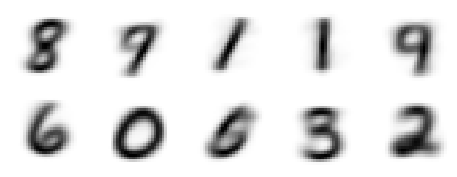

In [51]:
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [52]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

In [53]:
accuracy_score(np_MNIST_trainset_y, labels)

0.58258

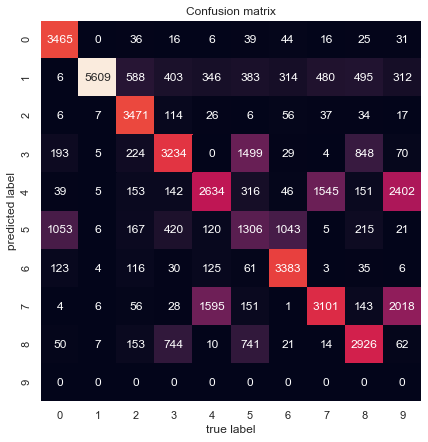

In [54]:
mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [55]:
# end of citation

## EM

In [56]:
# # We have to reduce dimensionality because of run-time
# pca = PCA(0.90, whiten=False)
# np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)
# np_MNIST_trainset_reduced.shape

2
4
6
8
10
12
14
16
18


Text(0.5, 1.0, 'Silhouette scores - MNIST')

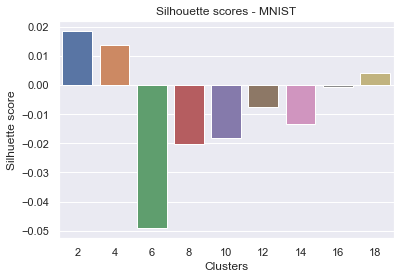

In [57]:
# calculating optimal number of clusters
silhouette_scores = []
for i in np.arange(2, 20, 2):
    print(i)
    em = GaussianMixture(n_components=i, random_state=0)
    silhouette_scores.append(silhouette_score(np_MNIST_trainset, em.fit_predict(np_MNIST_trainset)))

x = np.arange(2, 20, 2)
ax = sns.barplot(x=x, y=silhouette_scores)
ax.set(xlabel='Clusters', ylabel='Silhuette score')
ax.set_title('Silhouette scores - MNIST')

In [58]:
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset)

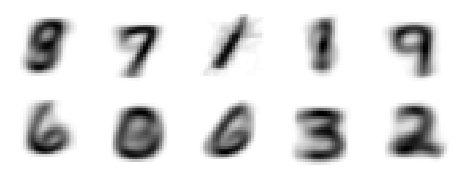

In [59]:
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = em.means_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [60]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

In [61]:
accuracy_score(np_MNIST_trainset_y, labels)

0.39474

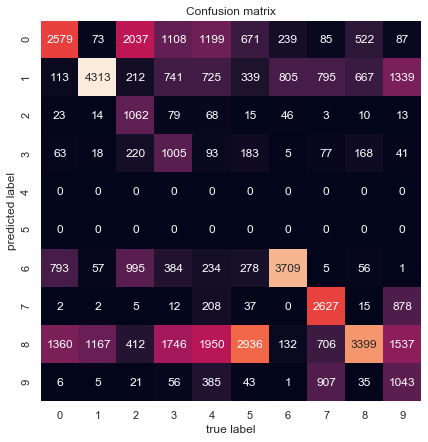

In [62]:
mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

## Credit

In [63]:
# standardize the data
x = X_train.values #returns a numpy array
normalizer = Normalizer().fit(x)
x_scaled = normalizer.transform(x)
X_train_normalized = pd.DataFrame(x_scaled, columns=X_train.columns)

## K-means

Text(0.5, 1.0, 'Silhouette scores - MNIST')

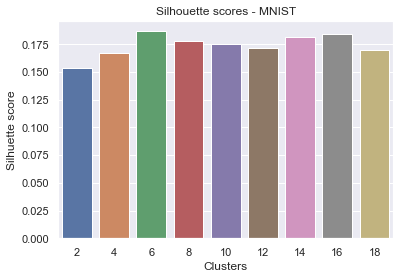

In [64]:
# calculating optimal number of clusters
silhouette_scores = []
elbow_scores = []

for i in np.arange(2, 20, 2):
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    silhouette_scores.append(silhouette_score(X_train_normalized, kmeans.fit_predict(X_train_normalized)))
    elbow_scores.append(kmeans.inertia_)

x = np.arange(2, 20, 2)
ax = sns.barplot(x=x, y=silhouette_scores)
ax.set(xlabel='Clusters', ylabel='Silhuette score')
ax.set_title('Silhouette scores - MNIST')

Text(0.5, 1.0, 'Elbow method - MNIST')

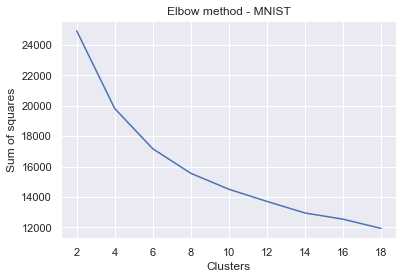

In [65]:
ax = sns.lineplot(x=x, y=elbow_scores)
ax.set(xlabel='Clusters', ylabel='Sum of squares')
ax.set_title('Elbow method - MNIST')

In [66]:
kmeans = KMeans(n_clusters=2, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized)

In [67]:
np.unique(clusters, return_counts=True)

(array([0, 1], dtype=int32), array([12667, 17238]))

In [68]:
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

In [69]:
accuracy_score(y_train, labels)

0.5823440896171209

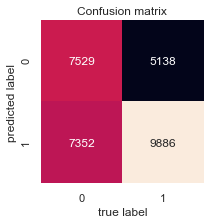

In [70]:
mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(3, 3)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

## EM

2
4
6
8
10
12
14
16
18


Text(0.5, 1.0, 'Silhouette scores - MNIST')

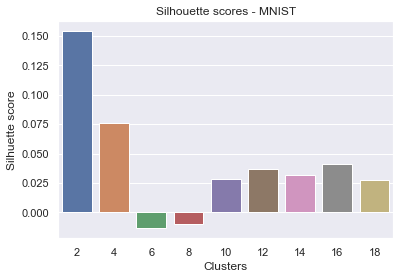

In [71]:
# calculating optimal number of clusters
silhouette_scores = []
for i in np.arange(2, 20, 2):
    print(i)
    em = GaussianMixture(n_components=i, random_state=0)
    silhouette_scores.append(silhouette_score(X_train, em.fit_predict(X_train)))

x = np.arange(2, 20, 2)
ax = sns.barplot(x=x, y=silhouette_scores)
ax.set(xlabel='Clusters', ylabel='Silhuette score')
ax.set_title('Silhouette scores - MNIST')

In [72]:
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train)

In [73]:
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

In [74]:
accuracy_score(y_train, labels)

0.5701722120046815

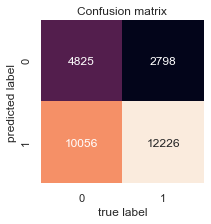

In [75]:
mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(3, 3)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

# Dimensionality reduction algorithms

## PCA

### MNIST

In [76]:
pca = PCA(2, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

Projection into 2D space

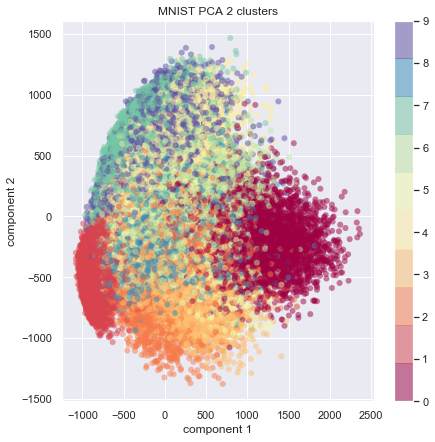

In [77]:
plt.figure(figsize=(7, 7))
plt.scatter(np_MNIST_trainset_reduced[:, 0], np_MNIST_trainset_reduced[:, 1],
            c=np_MNIST_trainset_y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('MNIST PCA 2 clusters')
plt.colorbar();

In [78]:
pca = PCA(0.9, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

In [79]:
np_MNIST_trainset_reduced.shape

(50000, 87)

In [80]:
pca.explained_variance_

array([333656.56509271, 243244.21106854, 212347.11674655, 185190.0261287 ,
       166870.84253403, 147968.46595142, 112302.835557  ,  98963.70595728,
        94633.02903894,  80882.25139024,  72538.47362887,  69067.30156627,
        58760.17622357,  58178.82928674,  54150.23252299,  50780.81745099,
        45460.54779631,  44080.03932357,  40609.13817195,  39375.9271604 ,
        36595.65913723,  34441.22403951,  32621.69093741,  31356.24121184,
        30398.16739657,  28865.01177791,  27914.27250414,  26936.35515244,
        25547.5705536 ,  23580.03372437,  22593.18148598,  22128.39744868,
        20640.75454268,  20066.48485189,  19595.82866024,  18638.77948376,
        17401.36593329,  16659.91013544,  16532.98684199,  16227.81075773,
        15642.67495026,  15233.74119214,  14423.24264156,  13725.69686768,
        13205.03785247,  12851.38030821,  12428.86424764,  12092.84942069,
        11645.21715017,  11032.32034545,  10977.67565683,  10734.83587965,
        10194.08769581,  

Text(0.5, 1.0, 'Explained variance')

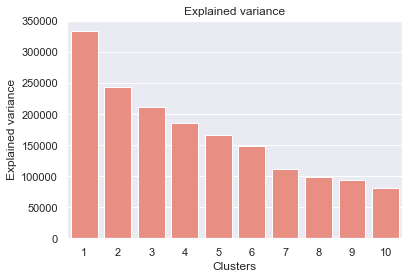

In [81]:
ax = sns.barplot(
    x=np.arange(1,11,1), 
    y=pca.explained_variance_[:10],
    color='salmon'
)
ax.set(xlabel='Clusters', ylabel='Explained variance')
ax.set_title('Explained variance')

Main eigenvectors

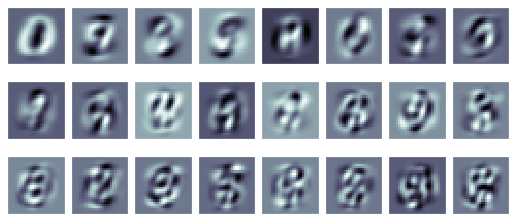

In [82]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(28, 28), cmap='bone')

Reconstruction

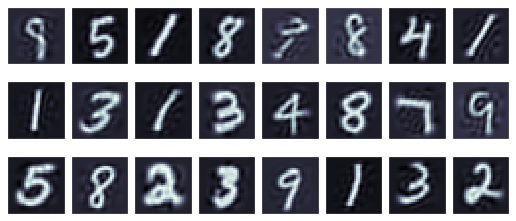

In [83]:
reconstructed = pca.inverse_transform(np_MNIST_trainset_reduced)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed[i].reshape(28, 28), cmap='bone')

### Credit

In [84]:
pca = PCA(2, whiten=False)
X_train_reduced = pca.fit_transform(X_train)

Projection into 2D space

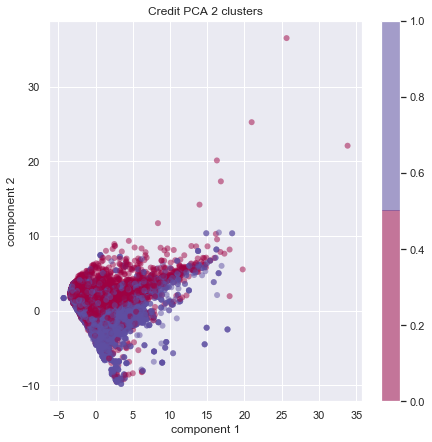

In [85]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Credit PCA 2 clusters')
plt.colorbar();

In [86]:
pca = PCA(0.9, whiten=False)
X_train_reduced = pca.fit_transform(X_train)

In [87]:
X_train_reduced.shape

(29905, 17)

In [88]:
pca.explained_variance_

array([6.59324992, 4.356024  , 2.43035181, 1.68594098, 1.59840999,
       1.22649787, 1.05713676, 1.02153315, 1.01329524, 0.95070566,
       0.93066543, 0.8797044 , 0.8451467 , 0.82334456, 0.78091728,
       0.76796348, 0.70059968])

Text(0.5, 1.0, 'Explained variance')

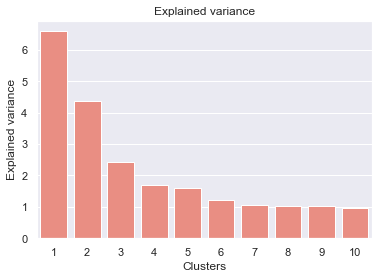

In [89]:
ax = sns.barplot(
    x=np.arange(1,11,1), 
    y=pca.explained_variance_[:10],
    color='salmon'
)
ax.set(xlabel='Clusters', ylabel='Explained variance')
ax.set_title('Explained variance')

## ICA

### MNIST

In [90]:
ica = FastICA(n_components=2, random_state=0, whiten=True)
np_MNIST_trainset_reduced = ica.fit_transform(np_MNIST_trainset)

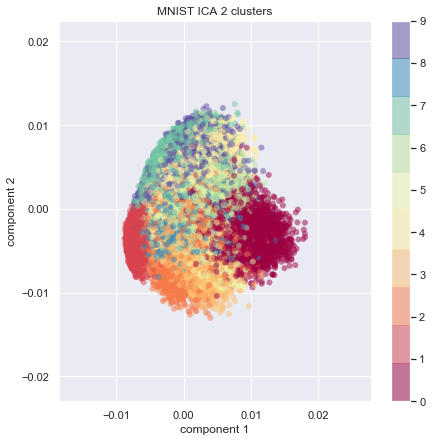

In [91]:
plt.figure(figsize=(7, 7))
plt.scatter(np_MNIST_trainset_reduced[:, 0], np_MNIST_trainset_reduced[:, 1],
            c=np_MNIST_trainset_y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('MNIST ICA 2 clusters')
plt.colorbar();

In [186]:
i_kurt = []
for i in np.arange(2, 30, 2):
    ica = FastICA(n_components=i, random_state=0, whiten=True)
    np_MNIST_trainset_reduced = ica.fit_transform(np_MNIST_trainset)
    kur = kurtosis(np_MNIST_trainset_reduced)
    i_kurt.append(np.mean(kur))

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA di

Text(0.5, 1.0, 'Kurtosis distribution')

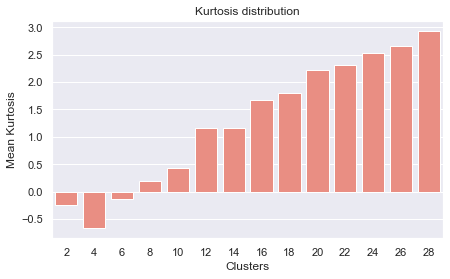

In [187]:
plt.figure(figsize=(7, 4))

ax = sns.barplot(
    x=np.arange(2,30,2), 
    y=i_kurt,
    color='salmon'
)
ax.set(xlabel='Clusters', ylabel='Mean Kurtosis')
ax.set_title('Kurtosis distribution')

In [188]:
ica = FastICA(n_components=40, random_state=0, whiten=True)
np_MNIST_trainset_reduced = ica.fit_transform(np_MNIST_trainset)

Text(0.5, 1.0, 'Kurtosis distribution')

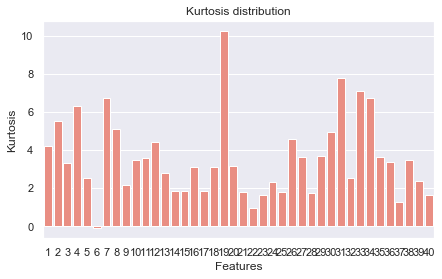

In [189]:
plt.figure(figsize=(7, 4))

ax = sns.barplot(
    x=np.arange(1,len(kurtosis(np_MNIST_trainset_reduced))+1,1), 
    y=kurtosis(np_MNIST_trainset_reduced),
    color='salmon'
)
ax.set(xlabel='Features', ylabel='Kurtosis')
ax.set_title('Kurtosis distribution')

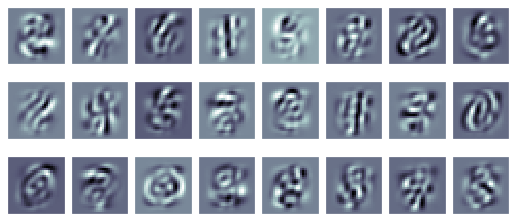

In [96]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(ica.components_[i].reshape(28, 28), cmap='bone')

Reconstruction

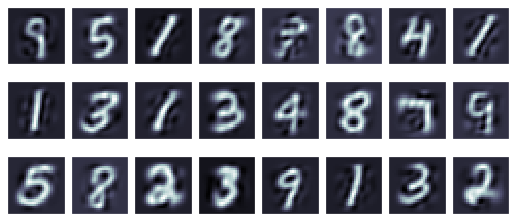

In [97]:
reconstructed = ica.inverse_transform(np_MNIST_trainset_reduced)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed[i].reshape(28, 28), cmap='bone')

### Credit

In [98]:
ica = FastICA(n_components=2, random_state=0, whiten=True)
X_train_reduced = ica.fit_transform(X_train)

Projection onto 2D space

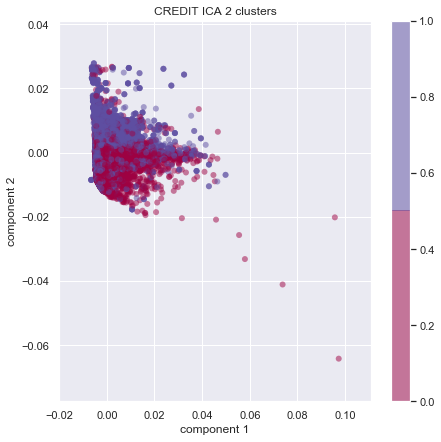

In [99]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('CREDIT ICA 2 clusters')
plt.colorbar();

In [100]:
ica = FastICA(n_components=10, random_state=0, whiten=True)
X_train_reduced = ica.fit_transform(X_train)

Text(0.5, 1.0, 'Kurtosis distribution')

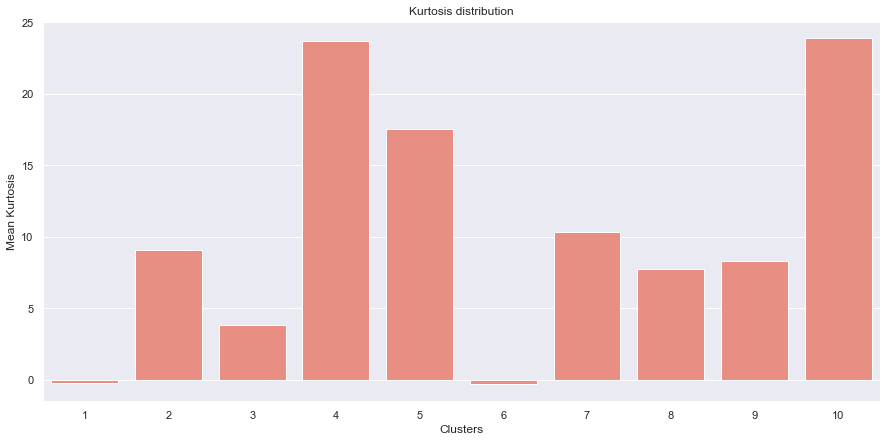

In [101]:
comp_kurtosis = []
for c in ica.components_:
    comp_kurtosis.append(kurtosis(c))


plt.figure(figsize=(15, 7))

ax = sns.barplot(
    x=np.arange(1,11,1), 
    y=comp_kurtosis,
    color='salmon'
)
ax.set(xlabel='Clusters', ylabel='Mean Kurtosis')
ax.set_title('Kurtosis distribution')

In [102]:
X_train_reduced.shape

(29905, 10)

## Randomized projection

### MNIST

In [103]:
transformer = random_projection.GaussianRandomProjection(n_components=2)
np_MNIST_trainset_reduced = transformer.fit_transform(np_MNIST_trainset)

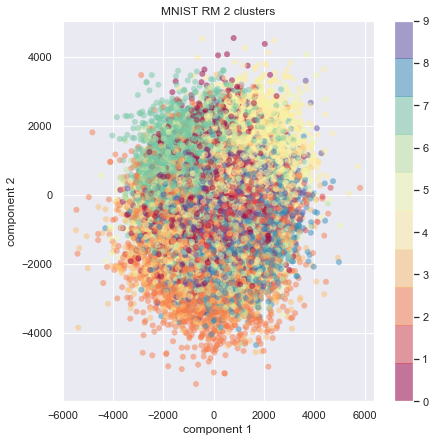

In [104]:
plt.figure(figsize=(7, 7))
plt.scatter(np_MNIST_trainset_reduced[:, 0], np_MNIST_trainset_reduced[:, 1],
            c=np_MNIST_trainset_y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('MNIST RM 2 clusters')
plt.colorbar();

In [105]:
transformer = random_projection.GaussianRandomProjection(n_components=40)
np_MNIST_trainset_reduced = transformer.fit_transform(np_MNIST_trainset)

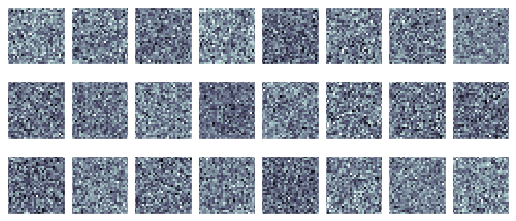

In [106]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(transformer.components_[i].reshape(28, 28), cmap='bone')

Reconstruction

In [107]:
np_MNIST_trainset_reduced.shape

(50000, 40)

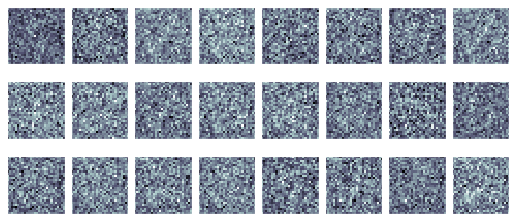

In [108]:
reconstructed = np.dot(np_MNIST_trainset_reduced, transformer.components_)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed[i].reshape(28, 28), cmap='bone')

### Credit

In [109]:
transformer = random_projection.GaussianRandomProjection(n_components=2)
X_train_reduced = transformer.fit_transform(X_train)

Projection onto 2D space

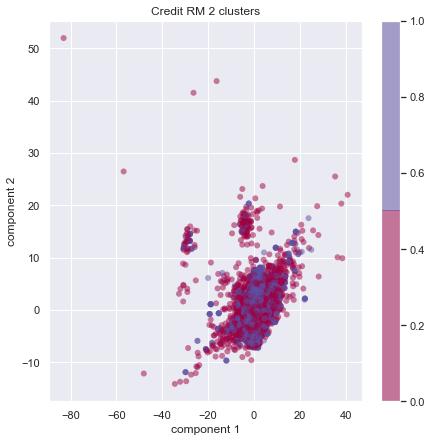

In [110]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Credit RM 2 clusters')
plt.colorbar();

In [111]:
transformer = random_projection.GaussianRandomProjection(n_components=40)
X_train_reduced = transformer.fit_transform(X_train)

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (30 < 40).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


## My dimensionality reduction algorithm - Feature agglomeration

### MNIST

In [112]:
agglo = FeatureAgglomeration(2)
np_MNIST_trainset_reduced = agglo.fit_transform(np_MNIST_trainset)

Projection into 2D space

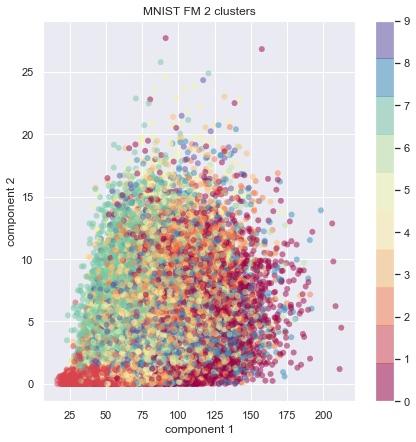

In [113]:
plt.figure(figsize=(7, 7))
plt.scatter(np_MNIST_trainset_reduced[:, 0], np_MNIST_trainset_reduced[:, 1],
            c=np_MNIST_trainset_y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('MNIST FM 2 clusters')
plt.colorbar();

In [180]:
agglo = FeatureAgglomeration(n_clusters=80)
np_MNIST_trainset_reduced = agglo.fit_transform(np_MNIST_trainset)

Reconstruction

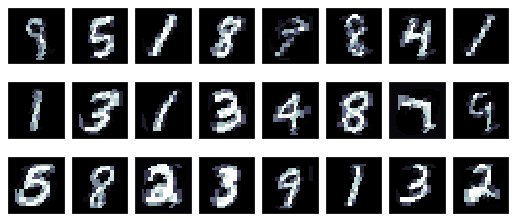

In [181]:
reconstructed = agglo.inverse_transform(np_MNIST_trainset_reduced)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed[i].reshape(28, 28), cmap='bone')

### Credit

In [182]:
agglo = FeatureAgglomeration(2)
X_train_reduced = agglo.fit_transform(X_train)

Text(0.5, 1.0, 'Credit FM 2 clusters')

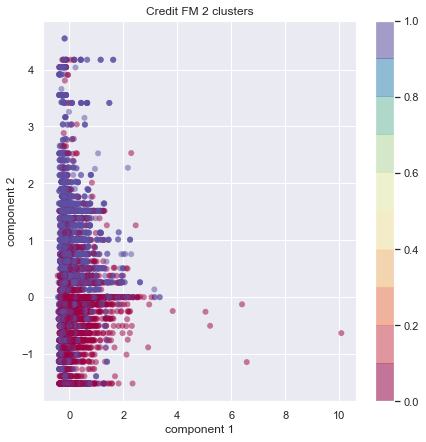

In [183]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.title('Credit FM 2 clusters')

# Clustering after dimensionality reduction

## MNIST

In [118]:
# number of features to reduce to
n = 49

### PCA - KM

0.58286


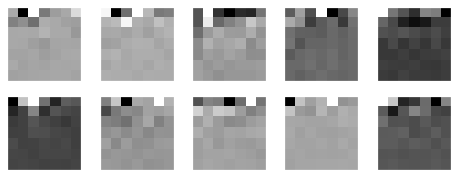

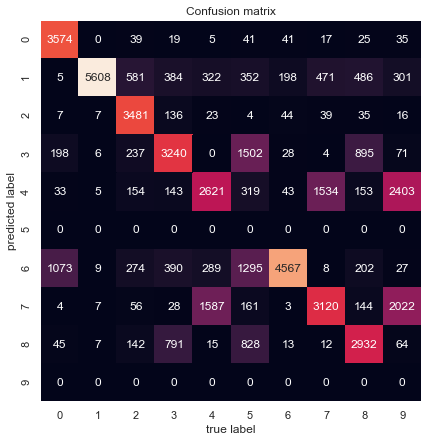

In [119]:
# dim reduction
pca = PCA(n, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

# clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset_reduced)

# plot
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, int(n ** (1/2)), int(n ** (1/2)))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### PCA - EM

0.66066


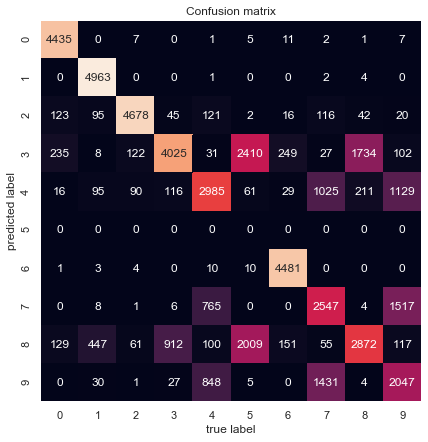

In [120]:
# dim reduction
pca = PCA(n, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

# clustering
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### ICA - KM

0.49954


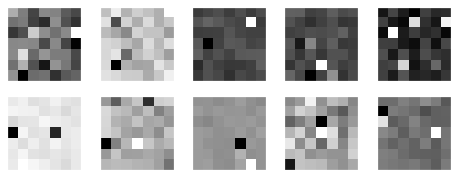

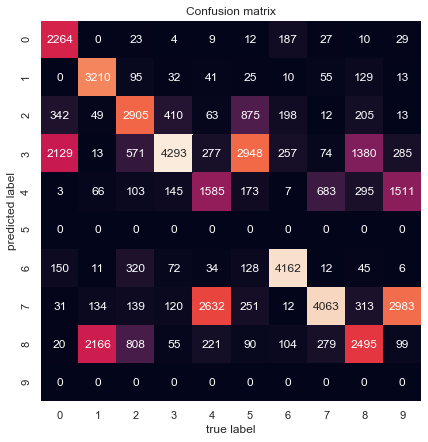

In [121]:
# dim reduction
ica = FastICA(n_components=n, random_state=0, whiten=True)
np_MNIST_trainset_reduced = ica.fit_transform(np_MNIST_trainset)

# clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset_reduced)

# plot
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, int(n ** (1/2)), int(n ** (1/2)))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### ICA - EM

0.69426


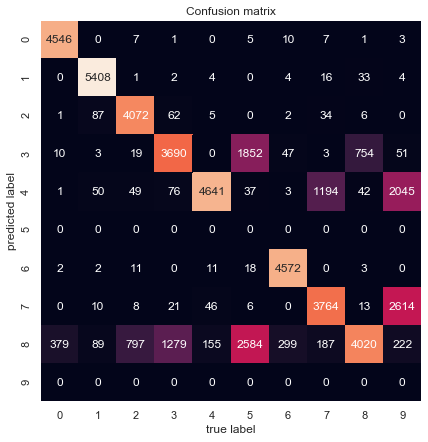

In [122]:
# dim reduction
ica = FastICA(n_components=n, random_state=0, whiten=True)
np_MNIST_trainset_reduced = ica.fit_transform(np_MNIST_trainset)

# clustering
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### RP - KM

0.49938


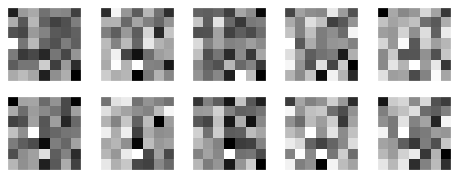

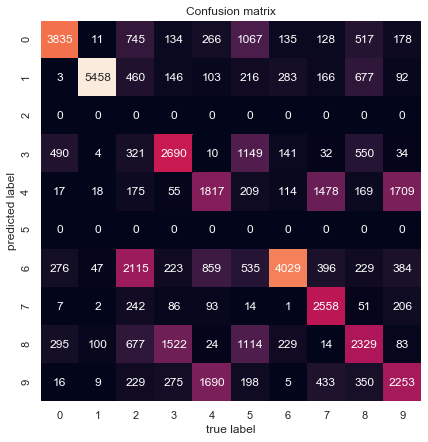

In [123]:
# dim reduction
transformer = random_projection.GaussianRandomProjection(n_components=n)
np_MNIST_trainset_reduced = transformer.fit_transform(np_MNIST_trainset)

# clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset_reduced)

# plot
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, int(n ** (1/2)), int(n ** (1/2)))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### RP - EM

0.64944


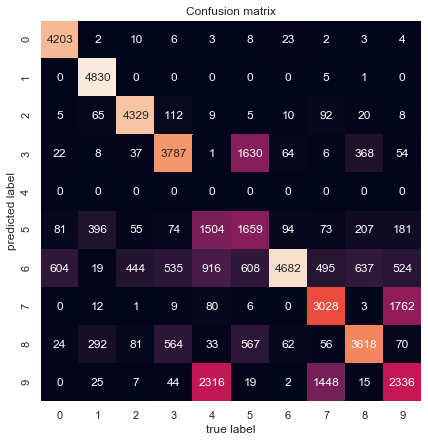

In [124]:
# dim reduction
transformer = random_projection.GaussianRandomProjection(n_components=n)
np_MNIST_trainset_reduced = transformer.fit_transform(np_MNIST_trainset)

# clustering
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### MY - KM

0.57746


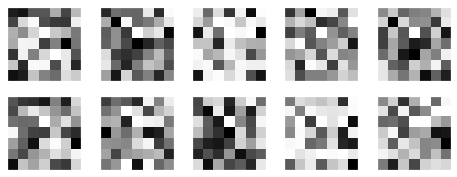

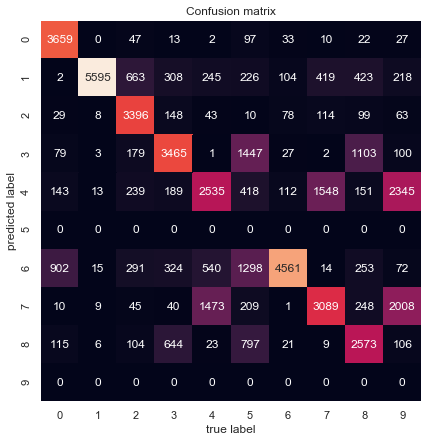

In [125]:
# dim reduction
agglo = FeatureAgglomeration(n)
np_MNIST_trainset_reduced = agglo.fit_transform(np_MNIST_trainset)

# clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset_reduced)

# plot
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, int(n ** (1/2)), int(n ** (1/2)))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### MY - EM

0.49424


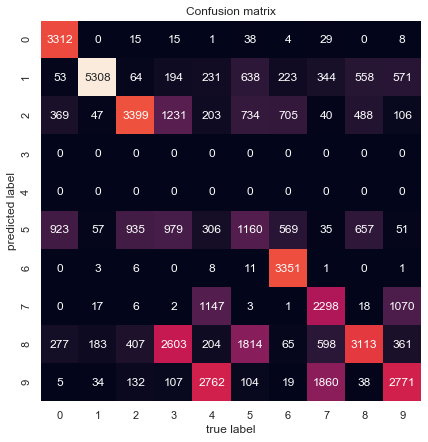

In [126]:
# dim reduction
agglo = FeatureAgglomeration(n)
np_MNIST_trainset_reduced = agglo.fit_transform(np_MNIST_trainset)

# clustering
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

## Credit

In [127]:
# dimensions
n = 10

### PCA - KM

0.5819093797023909


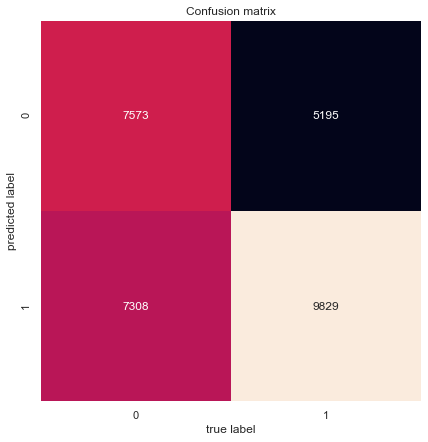

In [128]:
# dim reduction
pca = PCA(n, whiten=False)
X_train_normalized_reduced = pca.fit_transform(X_train_normalized)

# clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### PCA - EM

0.5123892325698044


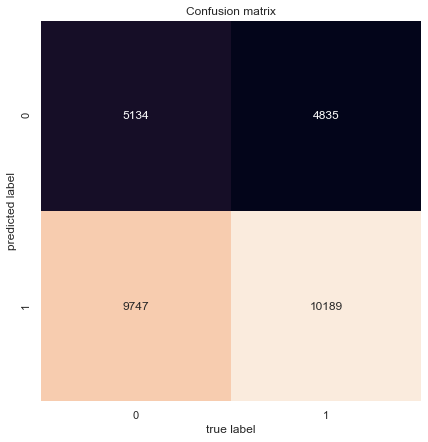

In [129]:
# dim reduction
pca = PCA(n, whiten=False)
X_train_normalized_reduced = pca.fit_transform(X_train_normalized)

# clustering
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### ICA - KM

0.5148637351613442


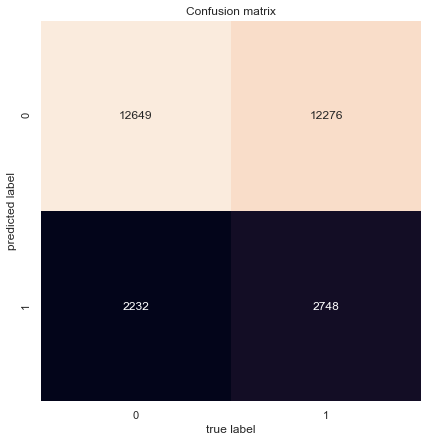

In [130]:
# dim reduction
ica = FastICA(n_components=n, random_state=0, whiten=True)
X_train_normalized_reduced = ica.fit_transform(X_train_normalized)

# clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### ICA - EM

0.519277712757064


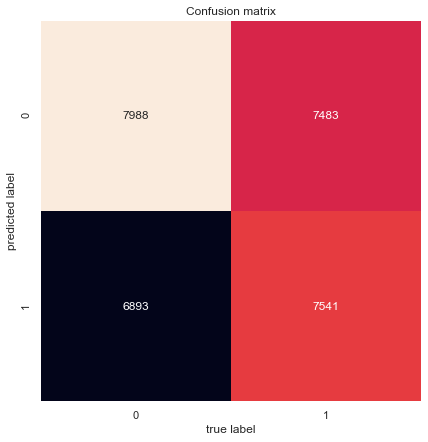

In [131]:
# dim reduction
ica = FastICA(n_components=n, random_state=0, whiten=True)
X_train_normalized_reduced = ica.fit_transform(X_train_normalized)

# clustering
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### RP - KM

0.5122889148971744


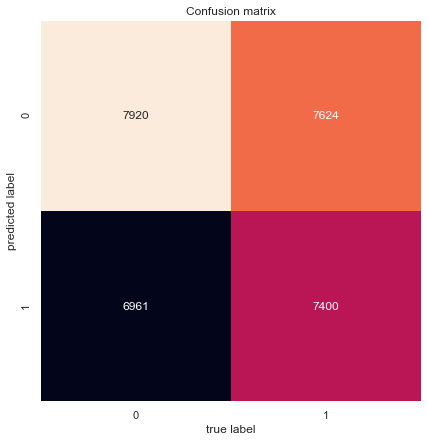

In [132]:
# dim reduction
transformer = random_projection.GaussianRandomProjection(n_components=n)
X_train_normalized_reduced = transformer.fit_transform(X_train_normalized)

# clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### RP - EM

0.5290419662263836


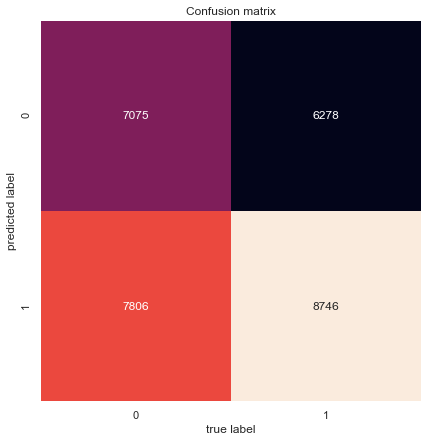

In [133]:
# dim reduction
transformer = random_projection.GaussianRandomProjection(n_components=n)
X_train_normalized_reduced = transformer.fit_transform(X_train_normalized)

# clustering
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### MY - KM

0.5220197291422839


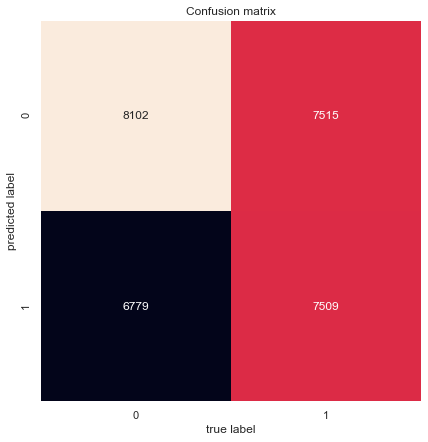

In [134]:
# dim reduction
agglo = FeatureAgglomeration(n)
X_train_normalized_reduced = agglo.fit_transform(X_train_normalized)

# clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

### MY - EM

0.5219528506938639


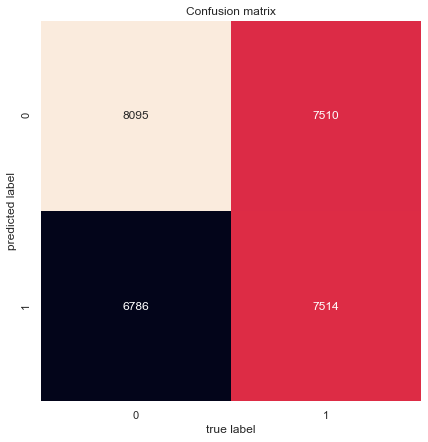

In [135]:
# dim reduction
agglo = FeatureAgglomeration(n)
X_train_normalized_reduced = agglo.fit_transform(X_train_normalized)

# clustering
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2)).set_title('Confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

# Neural Network after dimensionality reduction

In [136]:
pca = PCA(0.9, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

In [137]:
np_MNIST_trainset_reduced.shape

(50000, 87)

In [138]:
np_MNIST_valset_reduced = pca.transform(np_MNIST_valset)

In [139]:
np_MNIST_valset_reduced.shape

(10000, 87)

In [140]:
np_MNIST_testset_reduced = pca.transform(np_MNIST_testset)
np_MNIST_testset_reduced.shape

(10000, 87)

In [141]:
# convert data to tensors
X_train_tensor = torch.tensor(np_MNIST_trainset_reduced.astype(np.float32))
X_test_tensor = torch.tensor(np_MNIST_testset_reduced.astype(np.float32))
X_val_tensor = torch.tensor(np_MNIST_valset_reduced.astype(np.float32))

y_train_tensor = torch.tensor(np_MNIST_trainset_y.astype(np.int))
y_test_tensor = torch.tensor(np_MNIST_testset_y.astype(np.int))
y_val_tensor = torch.tensor(np_MNIST_valset_y.astype(np.int))

In [142]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [143]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

10000 10000 50000


In [144]:
trainloader = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [145]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
#         images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 87)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [146]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
#             images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [147]:
input_size = 87
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [148]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
# images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss
loss

tensor(27.0585, grad_fn=<NllLossBackward>)

In [149]:
lossDataBaseline, accDataBaseline, runtime = trainNN(model)

Epoch 0 - Training loss: 0.5411349503452059
Testing Loss  = 0.24407415091991425
Epoch 1 - Training loss: 0.18663143680033173
Testing Loss  = 0.1785265952348709
Epoch 2 - Training loss: 0.13753765477748858
Testing Loss  = 0.15895701944828033
Epoch 3 - Training loss: 0.11361582873804767
Testing Loss  = 0.15638652443885803
Epoch 4 - Training loss: 0.09332579485220535
Testing Loss  = 0.1459519863128662
Epoch 5 - Training loss: 0.07788525039584393
Testing Loss  = 0.14930689334869385
Epoch 6 - Training loss: 0.07017343897638066
Testing Loss  = 0.14536835253238678
Epoch 7 - Training loss: 0.06179296764764873
Testing Loss  = 0.14936581254005432
Epoch 8 - Training loss: 0.053024228421903914
Testing Loss  = 0.15195561945438385
Epoch 9 - Training loss: 0.048029953181227644
Testing Loss  = 0.1529768854379654
Epoch 10 - Training loss: 0.04072195138028094
Testing Loss  = 0.16284999251365662
Epoch 11 - Training loss: 0.036740200535692435
Testing Loss  = 0.1603804975748062
Epoch 12 - Training loss: 0.

In [150]:
print(np.mean(runtime))
# print(runtime)

2.0496912797292075


In [151]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [152]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

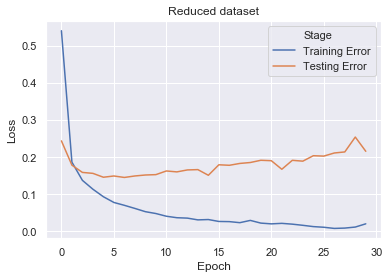

In [153]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Reduced dataset')

Text(0.5, 1.0, 'Reduced dataset')

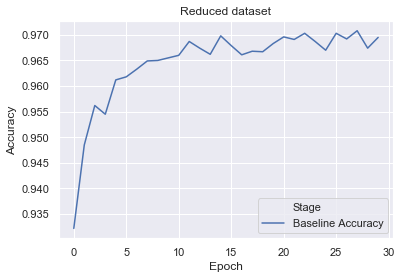

In [154]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Reduced dataset')

In [155]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [156]:
correctCount / allCount

0.9711

# NN on clusters after dim reductions

In [157]:
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
np_MNIST_trainset_reduced_clustered = kmeans.fit_predict(np_MNIST_trainset_reduced)

In [158]:
np_MNIST_valset_reduced_clustered = kmeans.fit_predict(np_MNIST_valset_reduced)

In [159]:
np_MNIST_testset_reduced_clustered = kmeans.fit_predict(np_MNIST_testset_reduced)

In [160]:
# add to the full dataset
np_MNIST_trainset_reduced_clustered_appended = np.c_[np_MNIST_trainset_reduced, np_MNIST_trainset_reduced_clustered]
np_MNIST_valset_reduced_clustered_appended = np.c_[np_MNIST_valset_reduced, np_MNIST_valset_reduced_clustered]
np_MNIST_testset_reduced_clustered_appended = np.c_[np_MNIST_testset_reduced, np_MNIST_testset_reduced_clustered]

In [161]:
np_MNIST_trainset_reduced_clustered_appended.shape

(50000, 88)

In [162]:
# convert data to tensors
X_train_tensor = torch.tensor(np_MNIST_trainset_reduced_clustered_appended.astype(np.float32))
X_test_tensor = torch.tensor(np_MNIST_testset_reduced_clustered_appended.astype(np.float32))
X_val_tensor = torch.tensor(np_MNIST_valset_reduced_clustered_appended.astype(np.float32))

y_train_tensor = torch.tensor(np_MNIST_trainset_y.astype(np.int))
y_test_tensor = torch.tensor(np_MNIST_testset_y.astype(np.int))
y_val_tensor = torch.tensor(np_MNIST_valset_y.astype(np.int))

In [163]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [164]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

10000 10000 50000


In [165]:
trainloader = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [166]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
#         images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 88)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [167]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
#             images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [168]:
input_size = 88
hidden_sizes = [64, 32]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [169]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
# images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss
loss

tensor(29.5602, grad_fn=<NllLossBackward>)

In [170]:
lossDataBaseline, accDataBaseline, runtime = trainNN(model)

Epoch 0 - Training loss: 0.6218225577074434
Testing Loss  = 0.27054697275161743
Epoch 1 - Training loss: 0.22083519904128732
Testing Loss  = 0.20871706306934357
Epoch 2 - Training loss: 0.17204317747784392
Testing Loss  = 0.17277544736862183
Epoch 3 - Training loss: 0.14616464770725354
Testing Loss  = 0.1784600168466568
Epoch 4 - Training loss: 0.12995536282094067
Testing Loss  = 0.16556859016418457
Epoch 5 - Training loss: 0.11532912858168753
Testing Loss  = 0.16650007665157318
Epoch 6 - Training loss: 0.10385956177267644
Testing Loss  = 0.16636116802692413
Epoch 7 - Training loss: 0.0952370405930173
Testing Loss  = 0.16146574914455414
Epoch 8 - Training loss: 0.08722745439560507
Testing Loss  = 0.1603628545999527
Epoch 9 - Training loss: 0.08220649291502188
Testing Loss  = 0.15672144293785095
Epoch 10 - Training loss: 0.07376015614992117
Testing Loss  = 0.159527987241745
Epoch 11 - Training loss: 0.06983295296091953
Testing Loss  = 0.1693076342344284
Epoch 12 - Training loss: 0.06891

In [171]:
print(np.mean(runtime))
# print(runtime)

1.9694745063781738


In [172]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [173]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

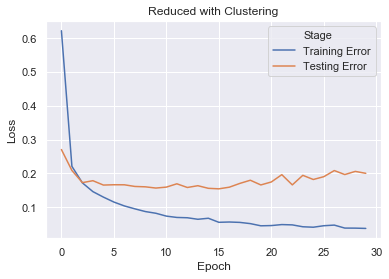

In [174]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Reduced with Clustering')

Text(0.5, 1.0, 'Reduced with Clustering')

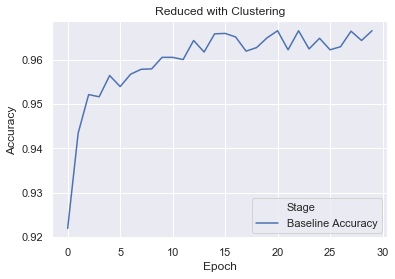

In [175]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Reduced with Clustering')

In [176]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [177]:
correctCount / allCount

0.9644

# END